In [15]:
import os
import re
from collections import defaultdict
import glob
import numpy as np 
import pandas as pd

def parse_fio_results(file_path):
    # Regular expressions
    bandwidth_regex = re.compile(r'WRITE: bw=(\d+(?:\.\d+)?)([MK]iB/s)')
    bandwidth_read_regex = re.compile(r'READ: bw=(\d+(?:\.\d+)?)([MK]iB/s)')
    iops_regex = re.compile(r'write: IOPS=(\d+)')
    iops_read_regex = re.compile(r'read: IOPS=(\d+)')
    latency_regex = re.compile(r'lat (\([mu]sec\)): min=\d+\.?\d*[km]?, max=\d+\.?\d*[km]?, avg=(\d+\.\d+[km]?), stdev=\d+\.?\d*')



    # Function to convert bandwidth to MiB/s
    def convert_bandwidth(value, unit):
        value = float(value)
        if unit == "KiB/s":
            return value / 1024  # Convert KiB/s to MiB/s
        return value  # Already in MiB/s

    results = {}

    with open(file_path, 'r') as file:
        last = 'read'
        for line in file:
            # Match write bandwidth
            if 'write' in line:
                last = 'write'
            elif 'read' in line:
                last = 'read'
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                value, unit = bw_match.groups()
                results['Bandwidth WRITE (MiB/s)'] = convert_bandwidth(value, unit)

            # Match read bandwidth
            bw_read_match = bandwidth_read_regex.search(line)
            if bw_read_match:
                value, unit = bw_read_match.groups()
                results['Bandwidth READ (MiB/s)'] = convert_bandwidth(value, unit)

            # Match write IOPS
            iops_match = iops_regex.search(line)
            if iops_match:
                results['IOPS WRITE'] = float(iops_match.group(1))

            # Match read IOPS
            iops_read_match = iops_read_regex.search(line)
            if iops_read_match:
                results['IOPS READ'] = float(iops_read_match.group(1))

            # Match latency
            lat_match = latency_regex.search(line)
            if lat_match:
                lat_val = float(lat_match.group(2))
                if lat_match.group(1) == '(usec)':
                    lat_val/=1000
                if last == 'read':
                    results['Latency READ (ms)'] = lat_val
                else:
                    results['Latency WRITE (ms)'] = lat_val


    return results


def extract_values(resultsfolder, file_names):
    resultsdict = {'ext4': {},  'xfs': {}, 'btrfs': {}, 'zfs': {}, 'f2fs': {}}
    cumulative_data = {file_name.split('_')[1]: defaultdict(list) for file_name in file_names}
    prepaths = [folder for folder in glob.glob(resultsfolder + '*/')]
    #print(prepaths)
    for prepath in prepaths:
        #print(prepath)
        filesystem = prepath.split('\\')[-2].split('_')[2]
        storage = prepath.split('\\')[-2].split('_')[3]
        folders = [folder for folder in glob.glob(prepath + '*/')]
        cumulative_data = {file_name.split('_')[1]: defaultdict(list) for file_name in file_names}
        for folder in folders:
            for file_name in file_names:
                file_path = os.path.join(folder, file_name)
                if os.path.exists(file_path):
                    try:
                        results = parse_fio_results(file_path)
                        for key, value in results.items():
                            cumulative_data[file_name.split('_')[1]][key].append(value)
                    except Exception as e:
                        print(f"Error parsing {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

        ranges = {}
        for file_name, metrics in cumulative_data.items():
            ranges[file_name] = {
                key: {'min': round(min(values),3), 'max':round(max(values),3), 'avg':round(sum(values) / len(values), 2)} if values else '-'
                for key, values in metrics.items()
            }
        resultsdict[filesystem][storage] = ranges
    return resultsdict




file_names = [
    'fio_database_test_output.txt',
    'fio_multimedia_test_output.txt',
    'fio_webserver_test_output.txt',
    'fio_archive_test_output.txt',
]

resultsdict = extract_values('./wyniki/', file_names)



In [18]:
# Function to generate all possible columns
def generate_columns(metrics):
    storage_types = ["HDD", "SSD", "NVME"]
    stats = ["MIN", "MAX", "AVG"]
    columns = ["File System"]
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                if stat == "AVG":
                    columns.append(f"{storage} {metric} {stat}")
    return columns


def extract_row_data(data, workload, columns):
    rows = []
    for fs, devices in data.items():
        row = [fs]
        for col in columns[1:]:  # Skip File System 
            if len(col.split()) > 3:
                col = col.split()
                storage, metric, stat = col[0],col[1]+' '+col[2],col[3]
            else:
                storage, metric, stat = col.split(" ", 2)
            if workload == 'database':
                if "Latency" in metric:
                    metric_key = f"{metric} (ms)"
                else:
                    metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
            elif workload == 'archive':
                if metric == "Latency":
                    metric_key = "Latency WRITE (ms)"
                else:
                    metric_key = f"{metric} WRITE (MiB/s)" if metric == "Bandwidth" else f"{metric} WRITE"
            else:
                if metric == "Latency":
                    metric_key = "Latency READ (ms)"
                else:
                    metric_key = f"{metric} READ (MiB/s)" if metric == "Bandwidth" else f"{metric} READ"
            # Extract value
            value = "N/A"
            for device_type, workloads in devices.items():
                if device_type.lower() == storage.lower() and workload in workloads:
                    value = workloads[workload].get(metric_key, {}).get(stat.lower(), "N/A")
                    break
            row.append(value)
        rows.append(row)
    return rows



# Workloads to process
workloads = ["database", "multimedia", "webserver", "archive"]

# Generate and display tables for each workload
for workload in workloads:
    if workload == "database":
        columns = generate_columns(["Bandwidth READ","Bandwidth WRITE", "IOPS READ","IOPS WRITE","Latency READ", "Latency WRITE"])
    else:
        columns = generate_columns(["Bandwidth", "IOPS", "Latency"])
    rows = extract_row_data(resultsdict, workload, columns)
    df = pd.DataFrame(rows, columns=columns)
    display(df.style.set_caption(f"Performance Metrics: {workload.capitalize()}").format(precision=3))

,File System,HDD Bandwidth READ AVG,HDD Bandwidth WRITE AVG,HDD IOPS READ AVG,HDD IOPS WRITE AVG,HDD Latency READ AVG,HDD Latency WRITE AVG,SSD Bandwidth READ AVG,SSD Bandwidth WRITE AVG,SSD IOPS READ AVG,SSD IOPS WRITE AVG,SSD Latency READ AVG,SSD Latency WRITE AVG,NVME Bandwidth READ AVG,NVME Bandwidth WRITE AVG,NVME IOPS READ AVG,NVME IOPS WRITE AVG,NVME Latency READ AVG,NVME Latency WRITE AVG
0,ext4,1.200,0.520,256.500,111.000,357.670,319.530,64.750,27.770,2403.000,6191.750,6.340,7.860,294.200,126.020,66.000,28.200,1.400,1.390
1,xfs,1.320,0.570,280.750,122.250,329.470,285.200,94.970,40.770,21.000,3759.000,4.180,5.480,349.000,150.000,78.250,33.250,1.160,1.110
2,btrfs,1.840,0.800,393.000,171.330,257.050,154.540,112.950,48.400,25.250,1975.250,2.730,5.650,386.670,166.000,87.000,37.000,1.110,0.980
3,zfs,16.800,7.240,3630.000,1560.670,23.480,27.410,19.000,8.170,4109.000,1765.330,21.210,24.250,42.980,18.440,2970.250,4062.250,10.630,12.850
4,f2fs,1.310,0.570,279.500,122.000,331.130,285.070,98.700,42.330,21.750,3876.250,3.980,5.190,307.330,131.670,69.000,29.330,1.290,1.290


,File System,HDD Bandwidth AVG,HDD IOPS AVG,HDD Latency AVG,SSD Bandwidth AVG,SSD IOPS AVG,SSD Latency AVG,NVME Bandwidth AVG,NVME IOPS AVG,NVME Latency AVG
0,ext4,138.000,1103.000,231.620,477.500,3818.250,35.450,1988.000,15.400,16.090
1,xfs,141.250,1129.000,226.530,496.250,3970.750,25.480,2184.750,17.000,14.620
2,btrfs,140.330,1122.670,227.710,486.000,3889.250,16.960,2187.330,17.000,14.540
3,zfs,555.330,4442.670,29.590,1649.670,12.670,8.870,3851.250,30.500,5.640
4,f2fs,132.000,1052.750,242.990,487.000,3898.250,0.050,2194.000,17.000,14.570


,File System,HDD Bandwidth AVG,HDD IOPS AVG,HDD Latency AVG,SSD Bandwidth AVG,SSD IOPS AVG,SSD Latency AVG,NVME Bandwidth AVG,NVME IOPS AVG,NVME Latency AVG
0,ext4,1.230,286.750,1771.300,265.000,63.250,9.590,1205.200,289.600,1.770
1,xfs,1.330,309.750,1640.380,270.000,64.000,9.180,1374.000,330.500,1.550
2,btrfs,1.320,306.330,1657.650,268.250,63.750,9.240,1374.000,330.330,1.550
3,zfs,86.400,20.000,18.520,61.400,14.000,33.230,106.550,24.750,20.200
4,f2fs,1.290,301.000,1687.830,267.500,63.500,9.250,1119.670,269.000,1.940


,File System,HDD Bandwidth AVG,HDD IOPS AVG,HDD Latency AVG,SSD Bandwidth AVG,SSD IOPS AVG,SSD Latency AVG,NVME Bandwidth AVG,NVME IOPS AVG,NVME Latency AVG
0,ext4,127.750,1569.250,162.920,173.880,2138.000,150.990,486.600,5985.000,47.330
1,xfs,140.000,1724.000,148.490,241.000,2964.000,94.180,645.500,7943.250,32.840
2,btrfs,134.670,1656.330,154.540,225.500,2773.250,102.830,451.670,5558.000,49.610
3,zfs,166.670,2049.670,124.690,210.000,2584.000,101.230,310.500,3821.750,77.320
4,f2fs,134.250,1649.250,155.190,237.000,2916.250,96.960,387.330,4766.670,55.640


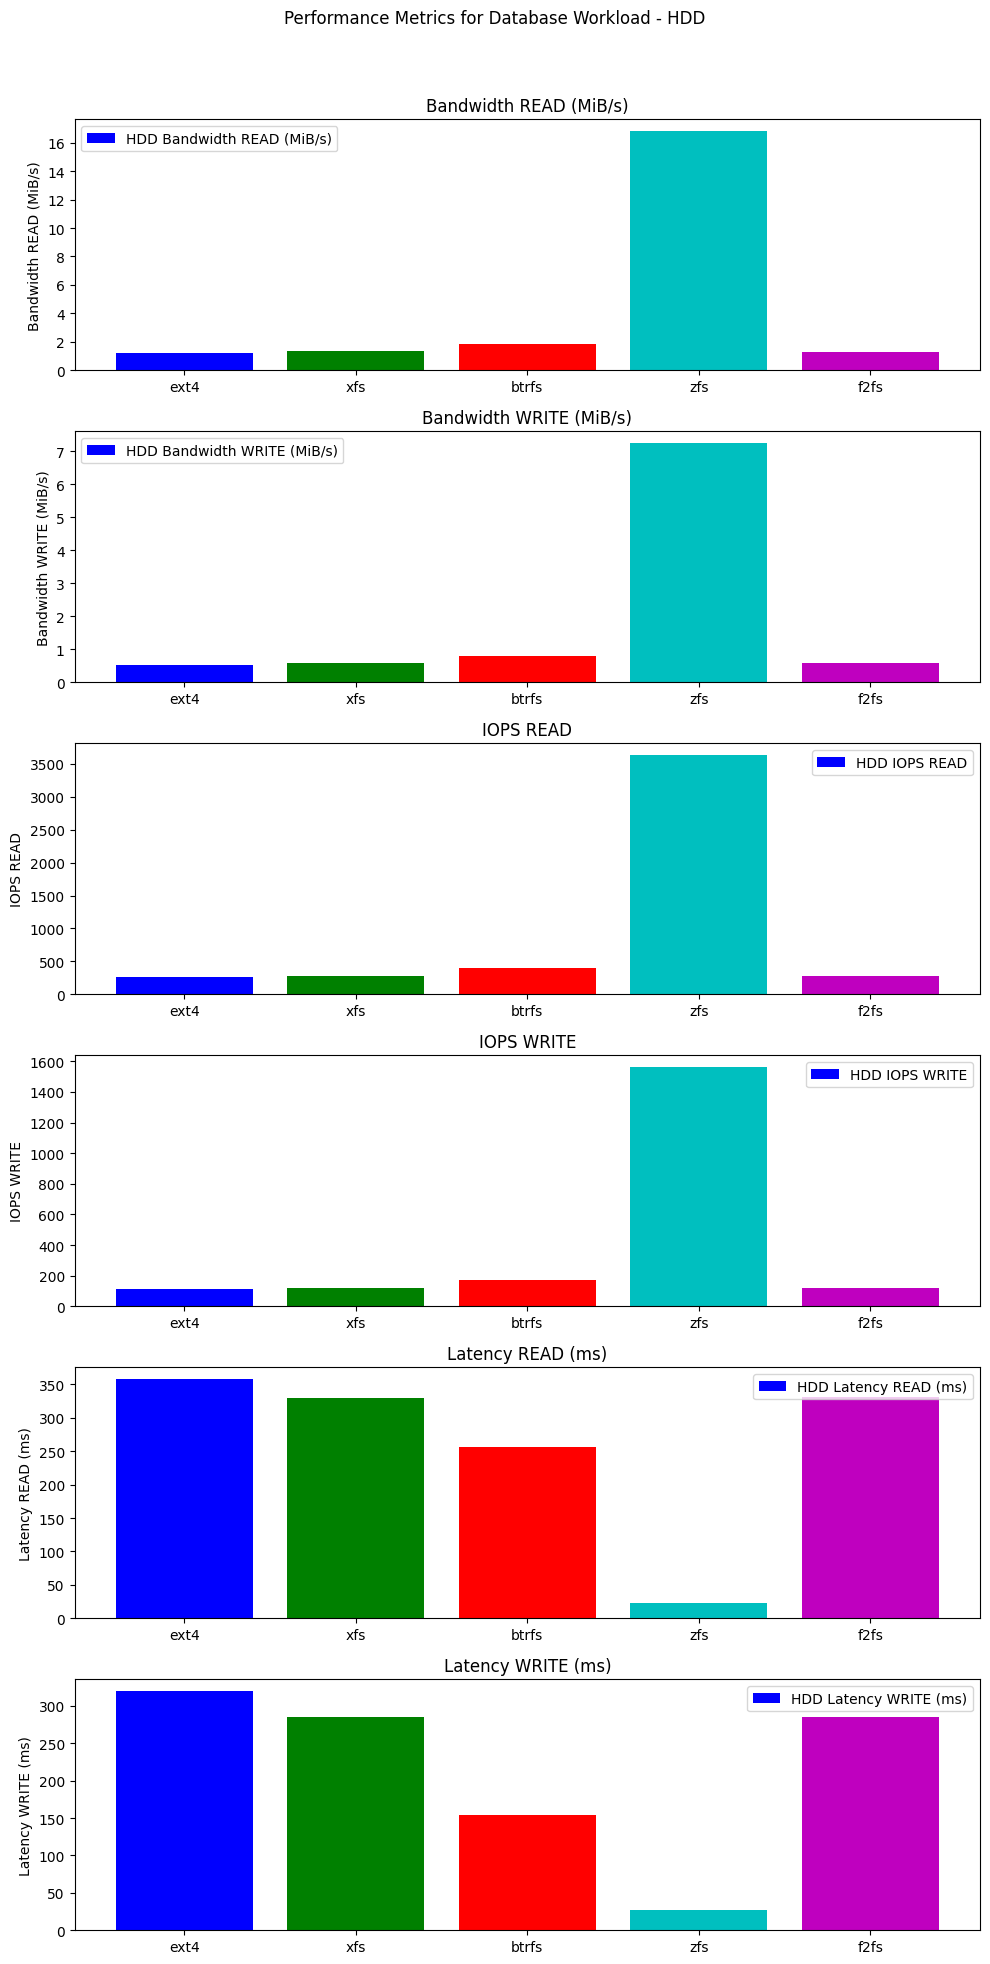

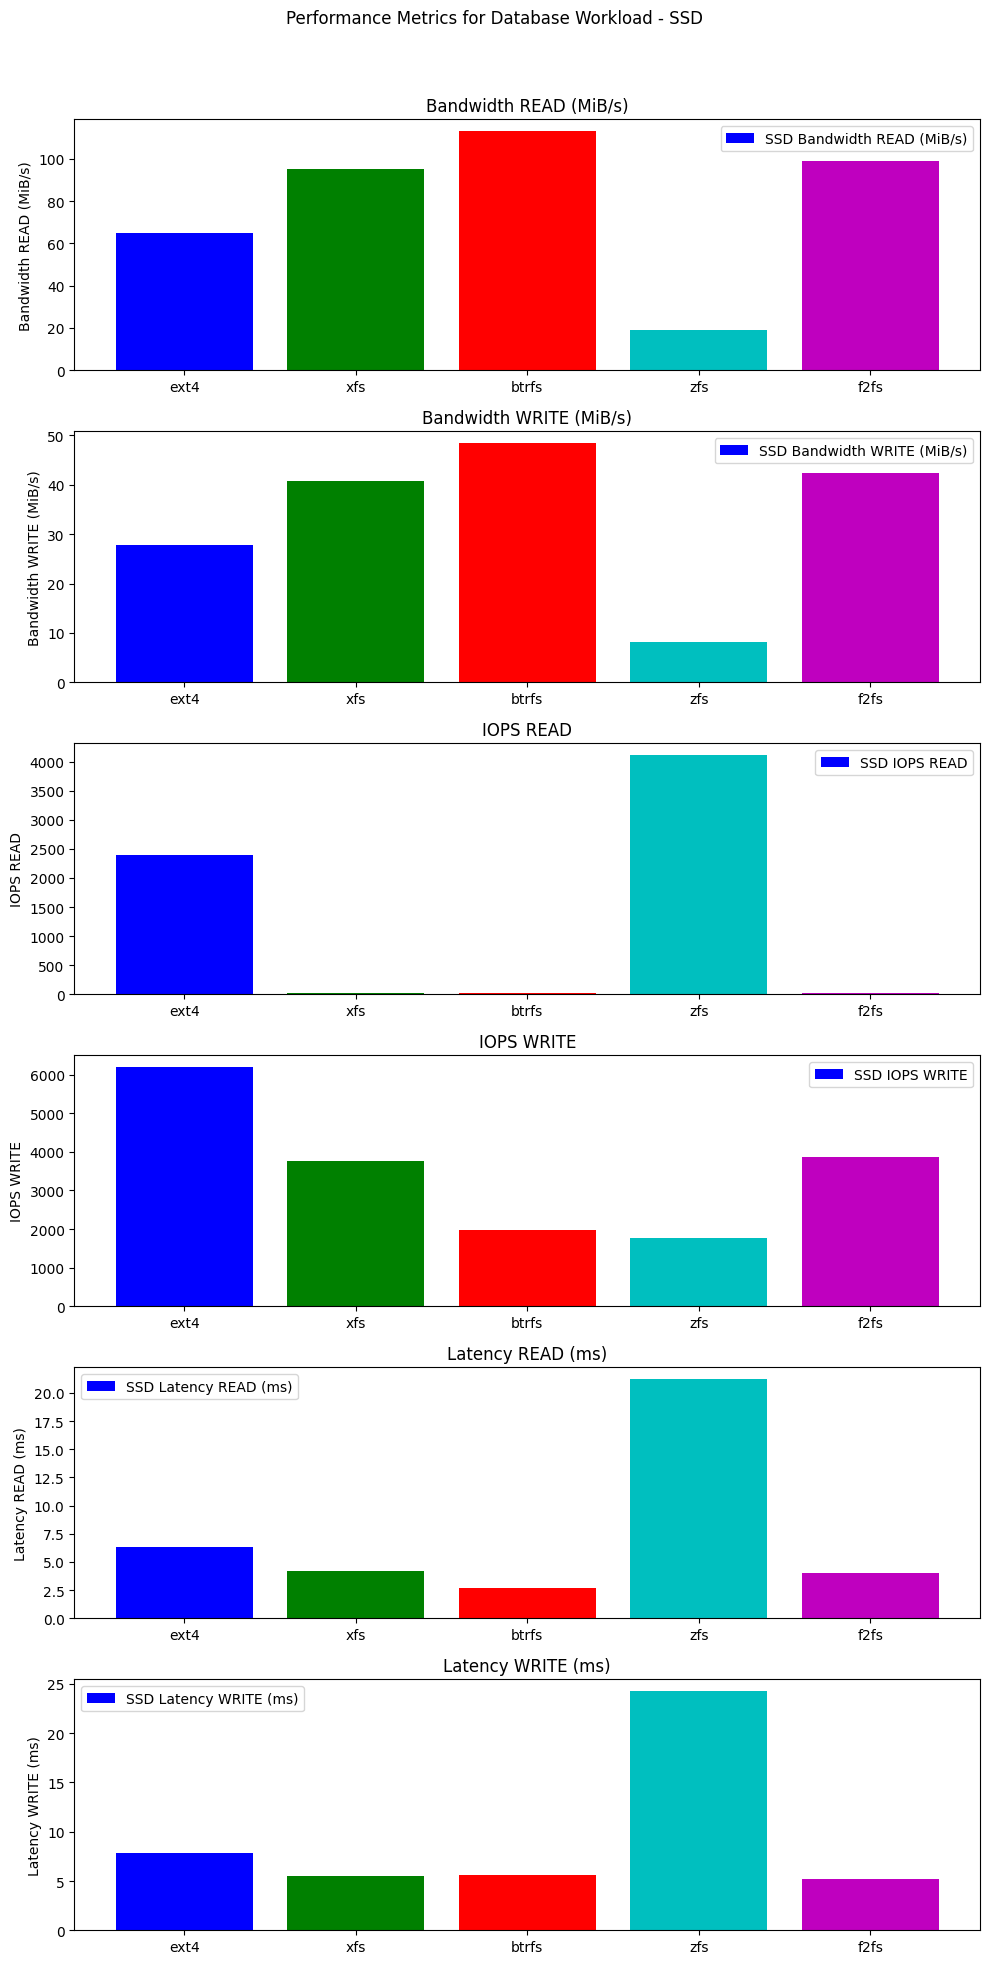

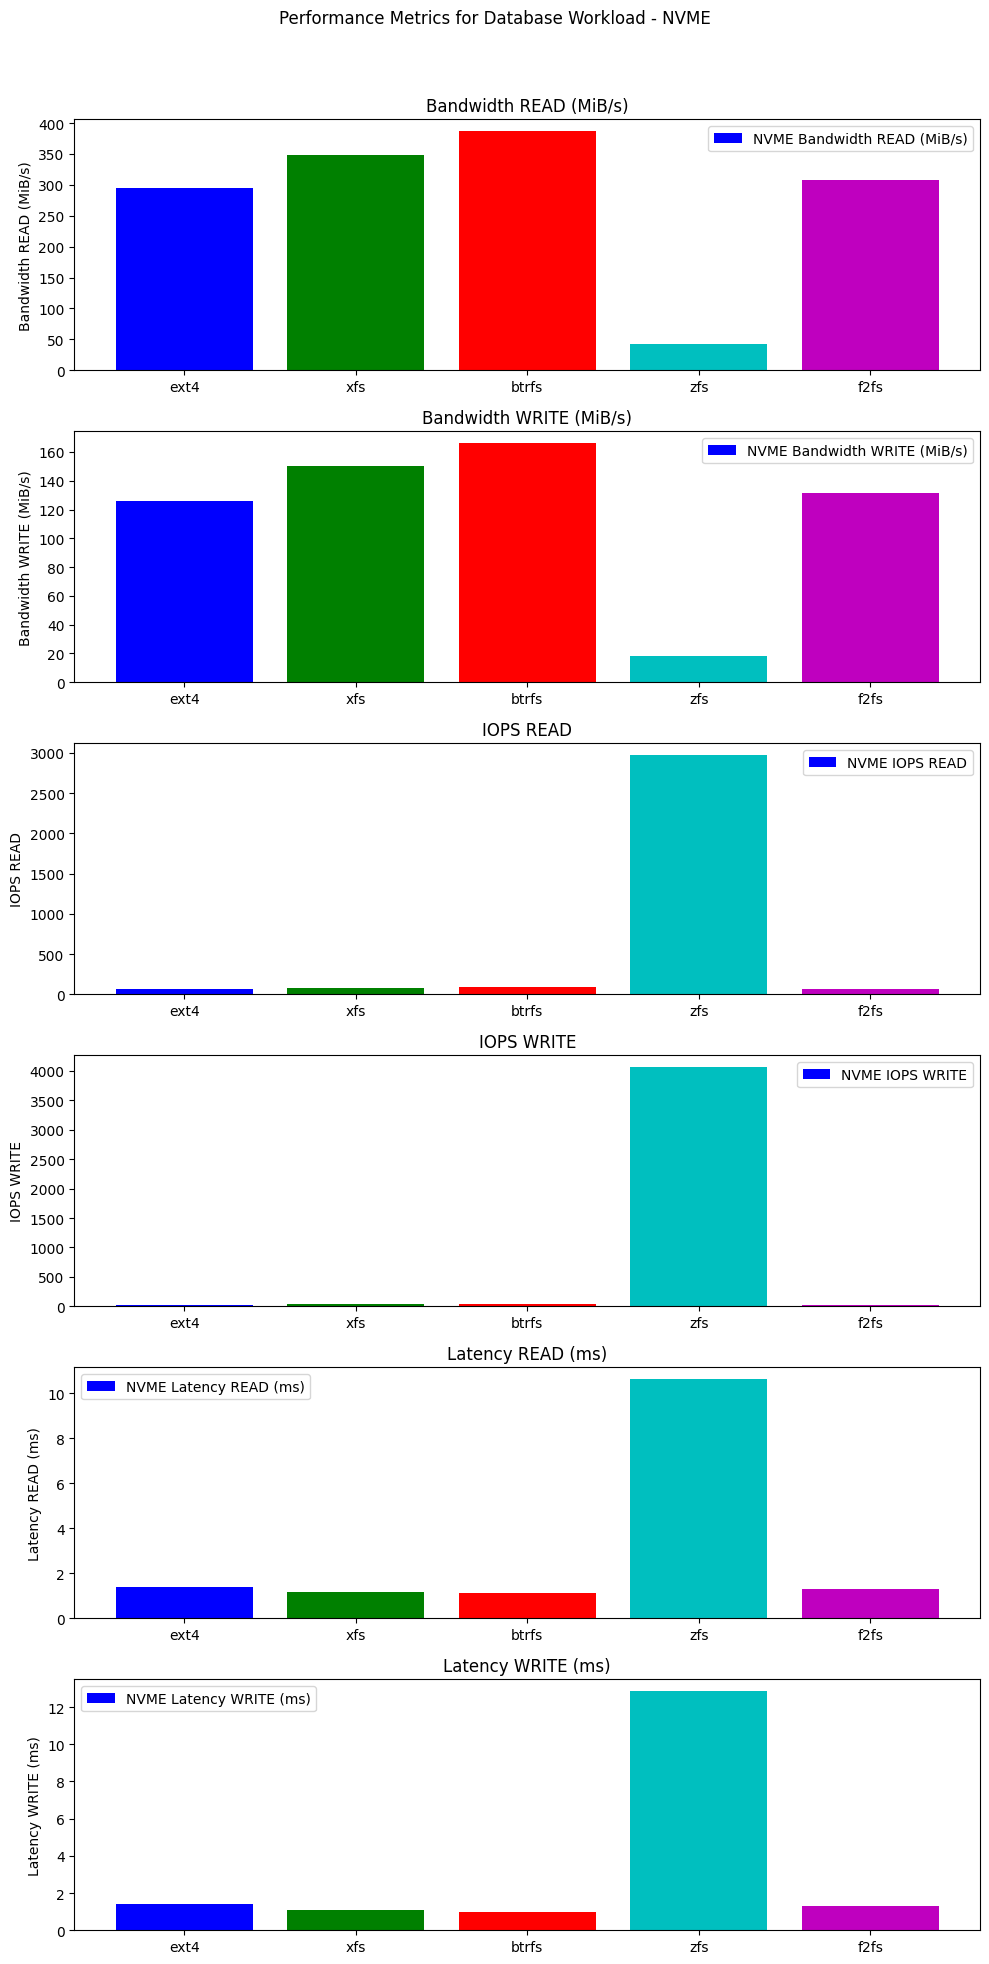

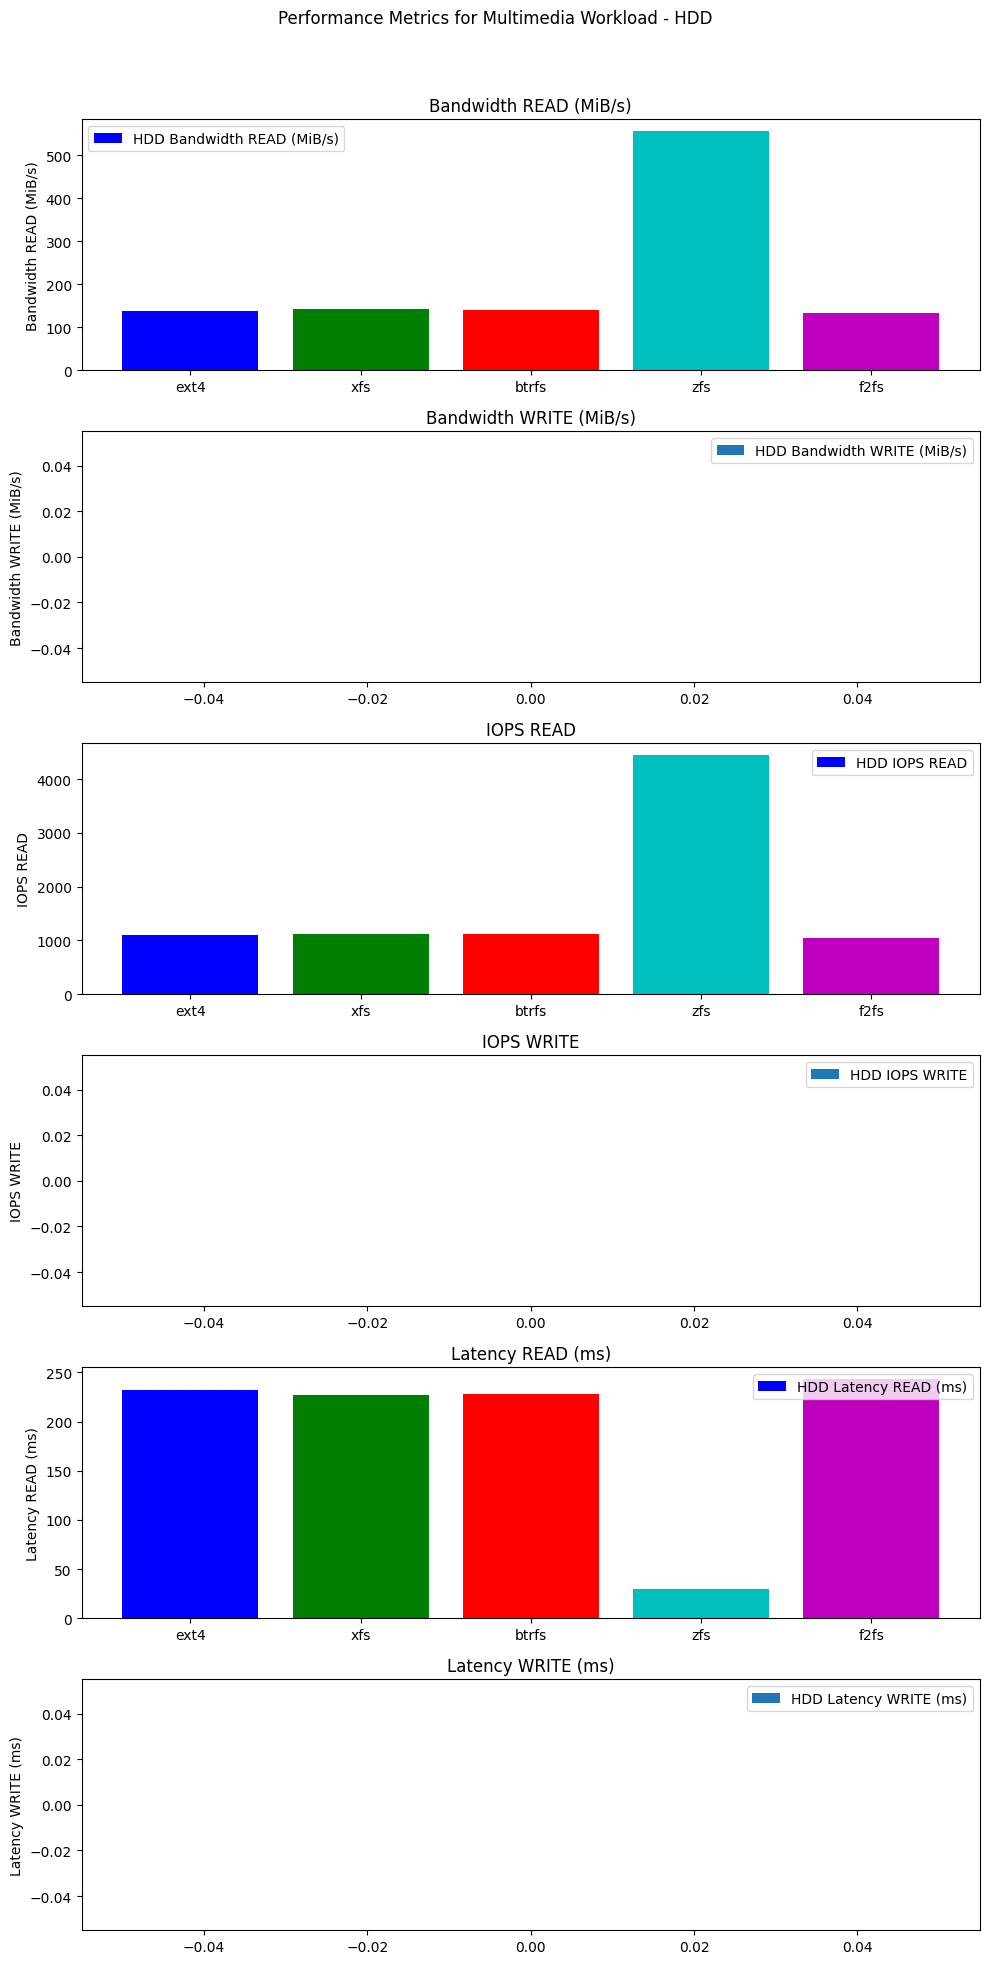

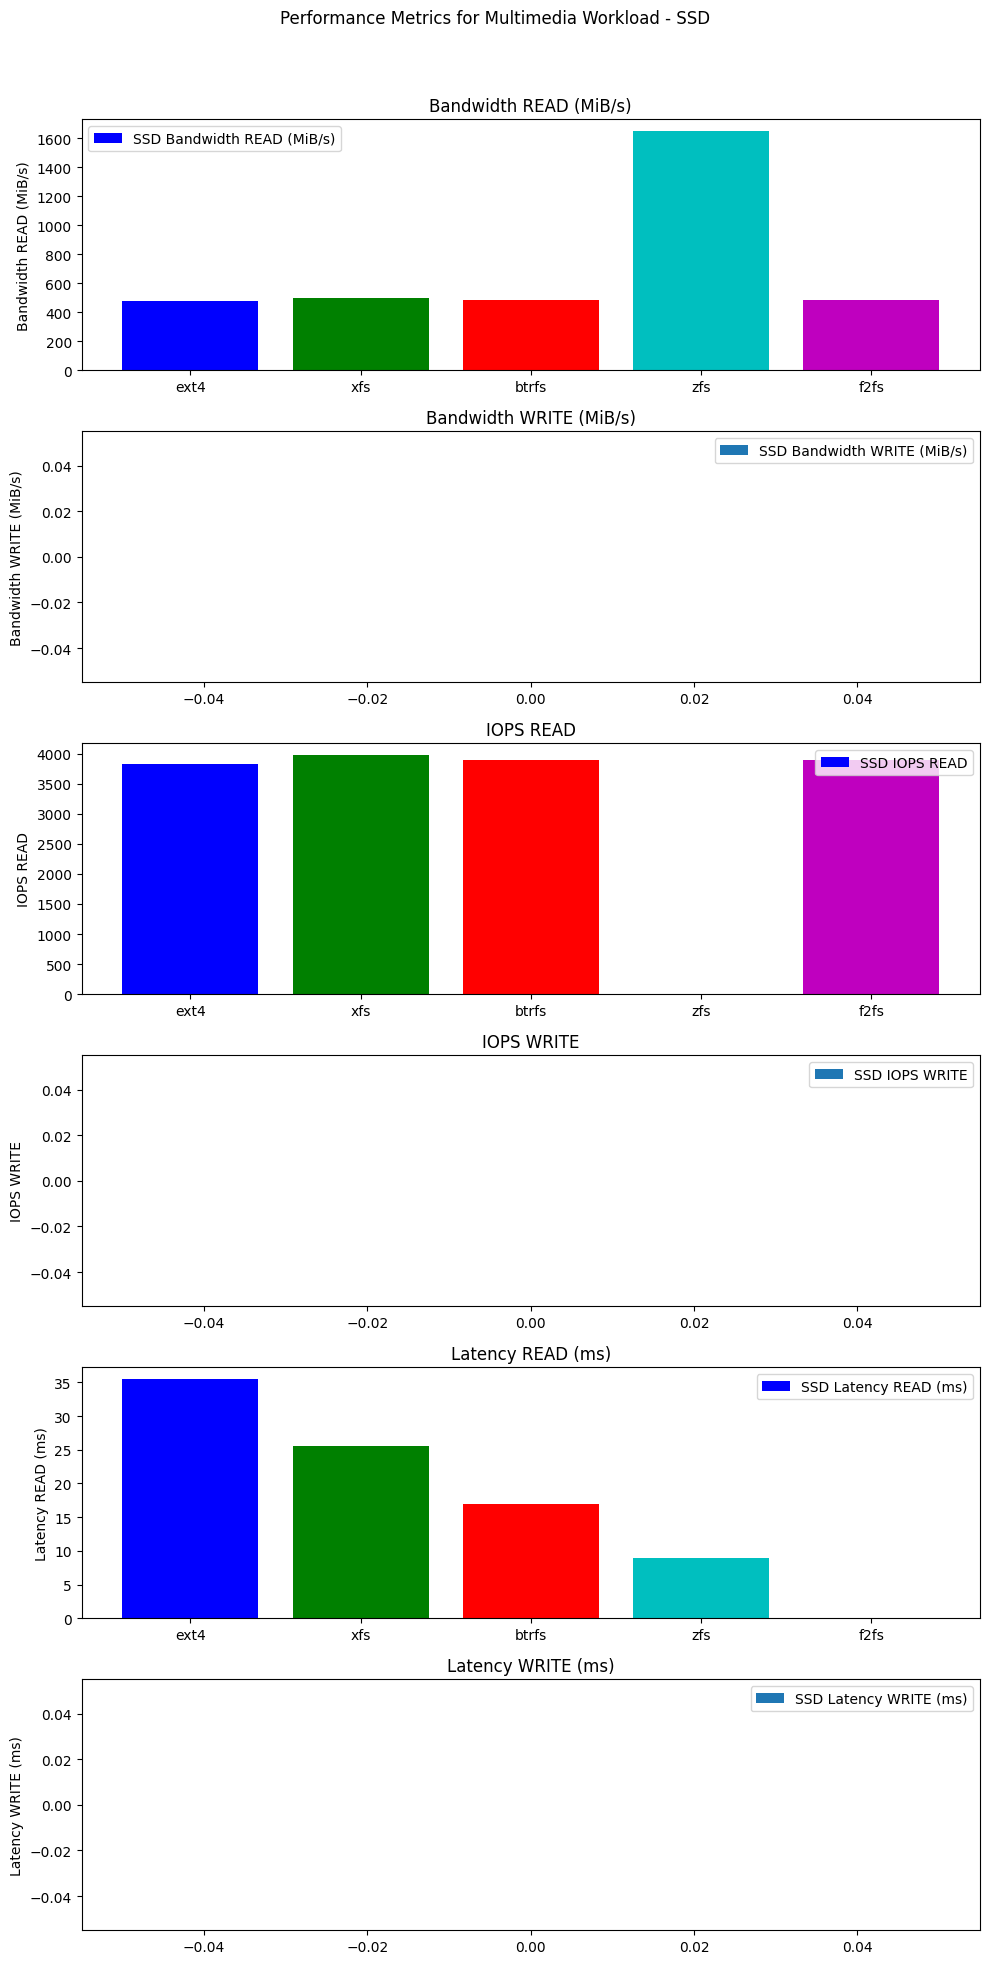

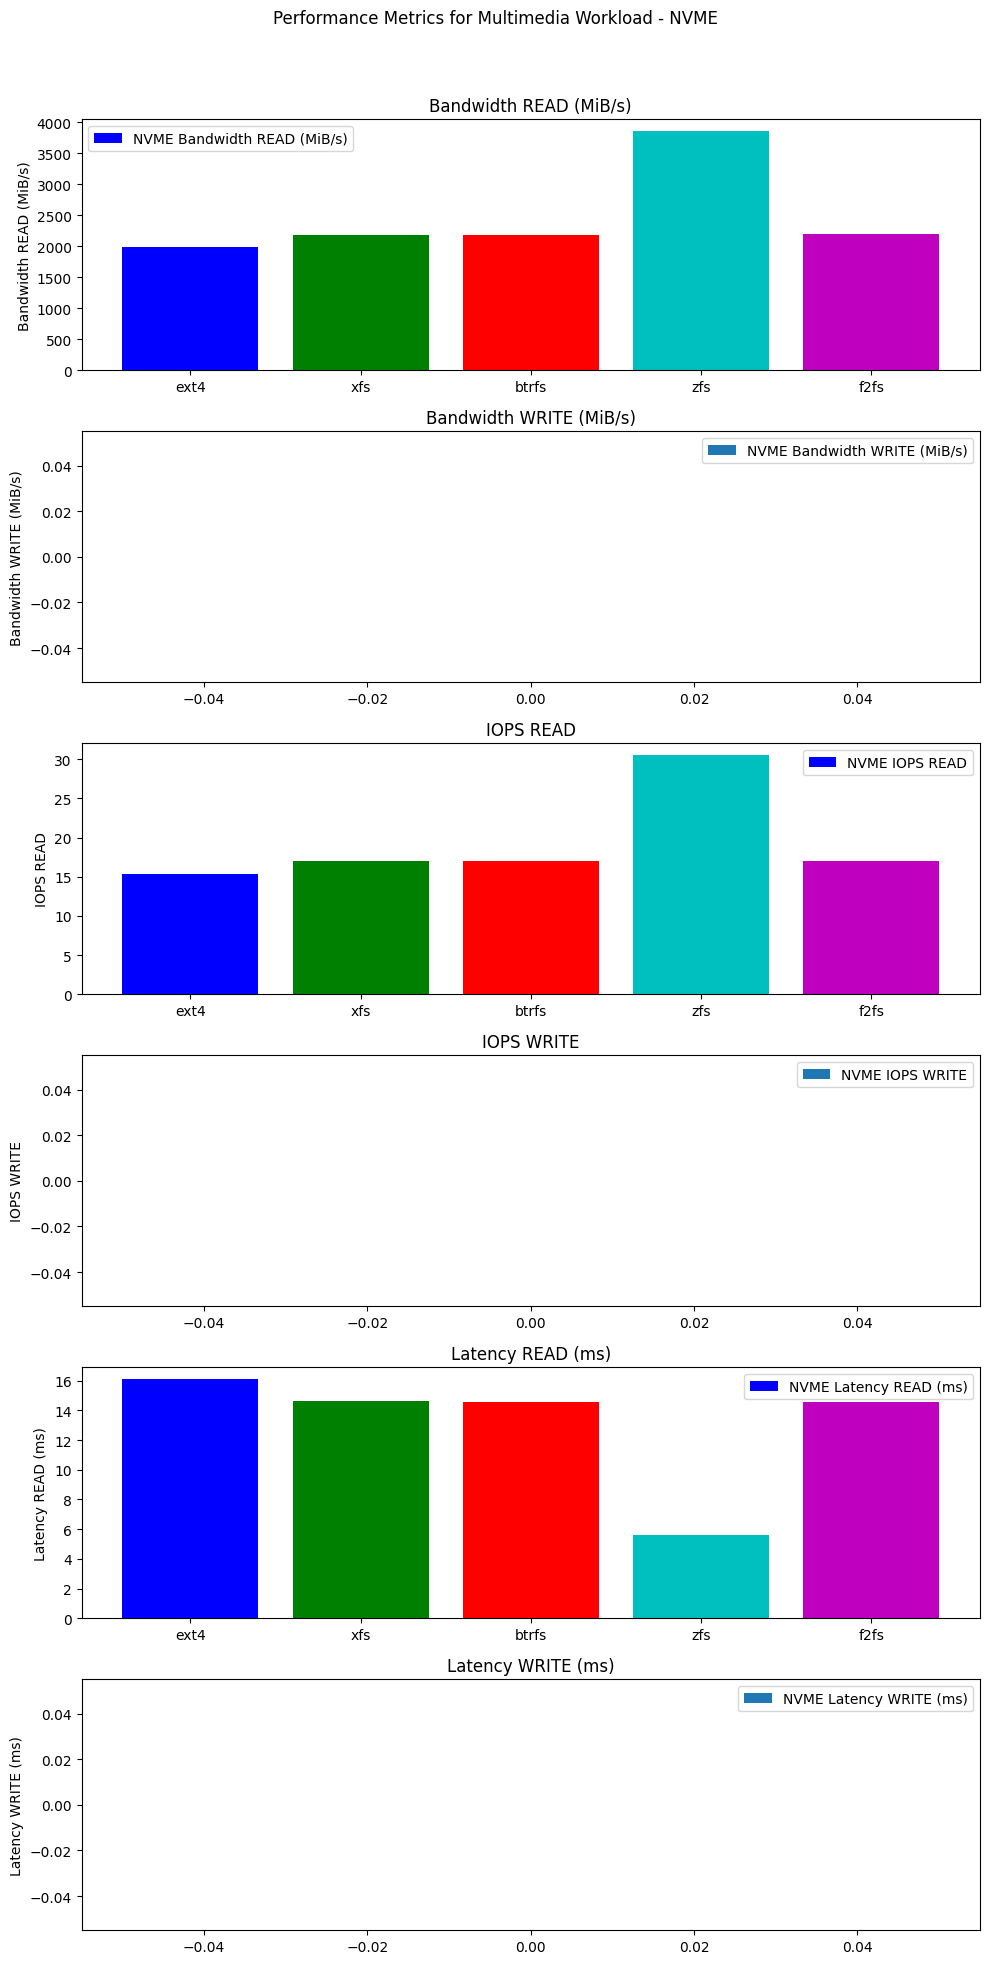

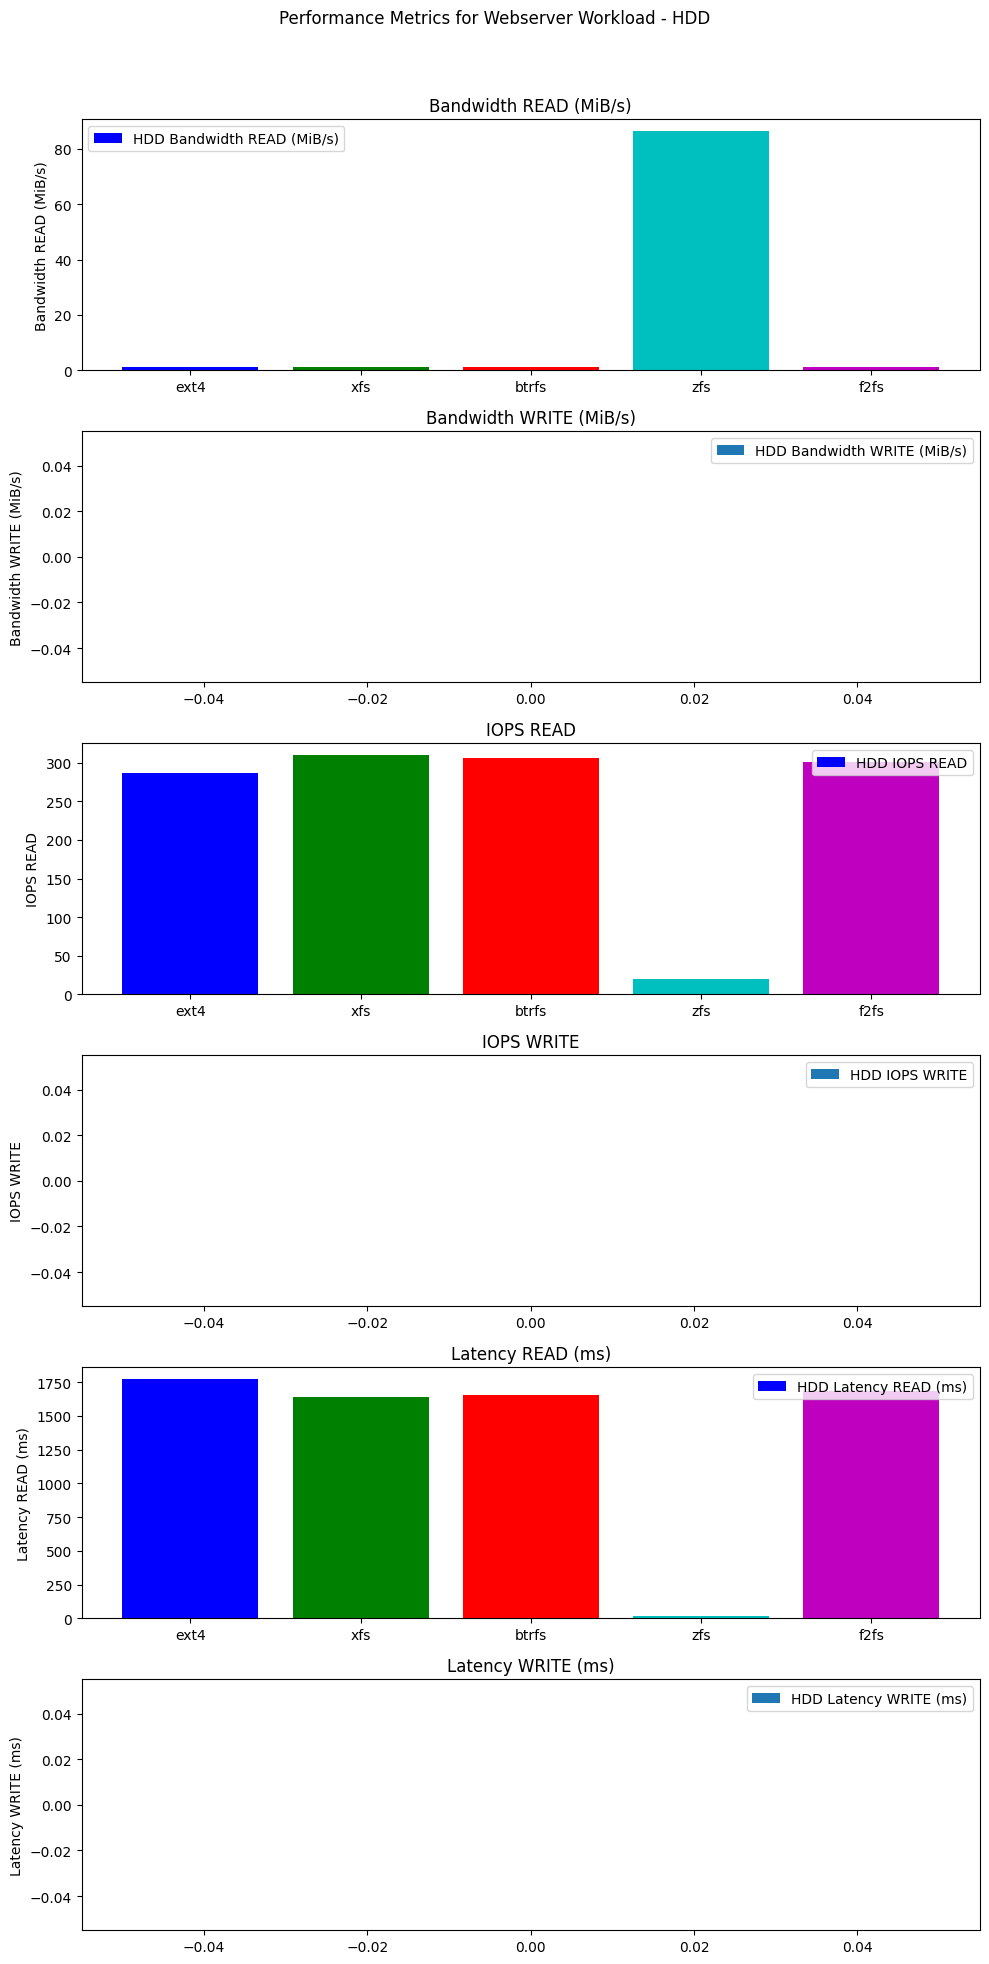

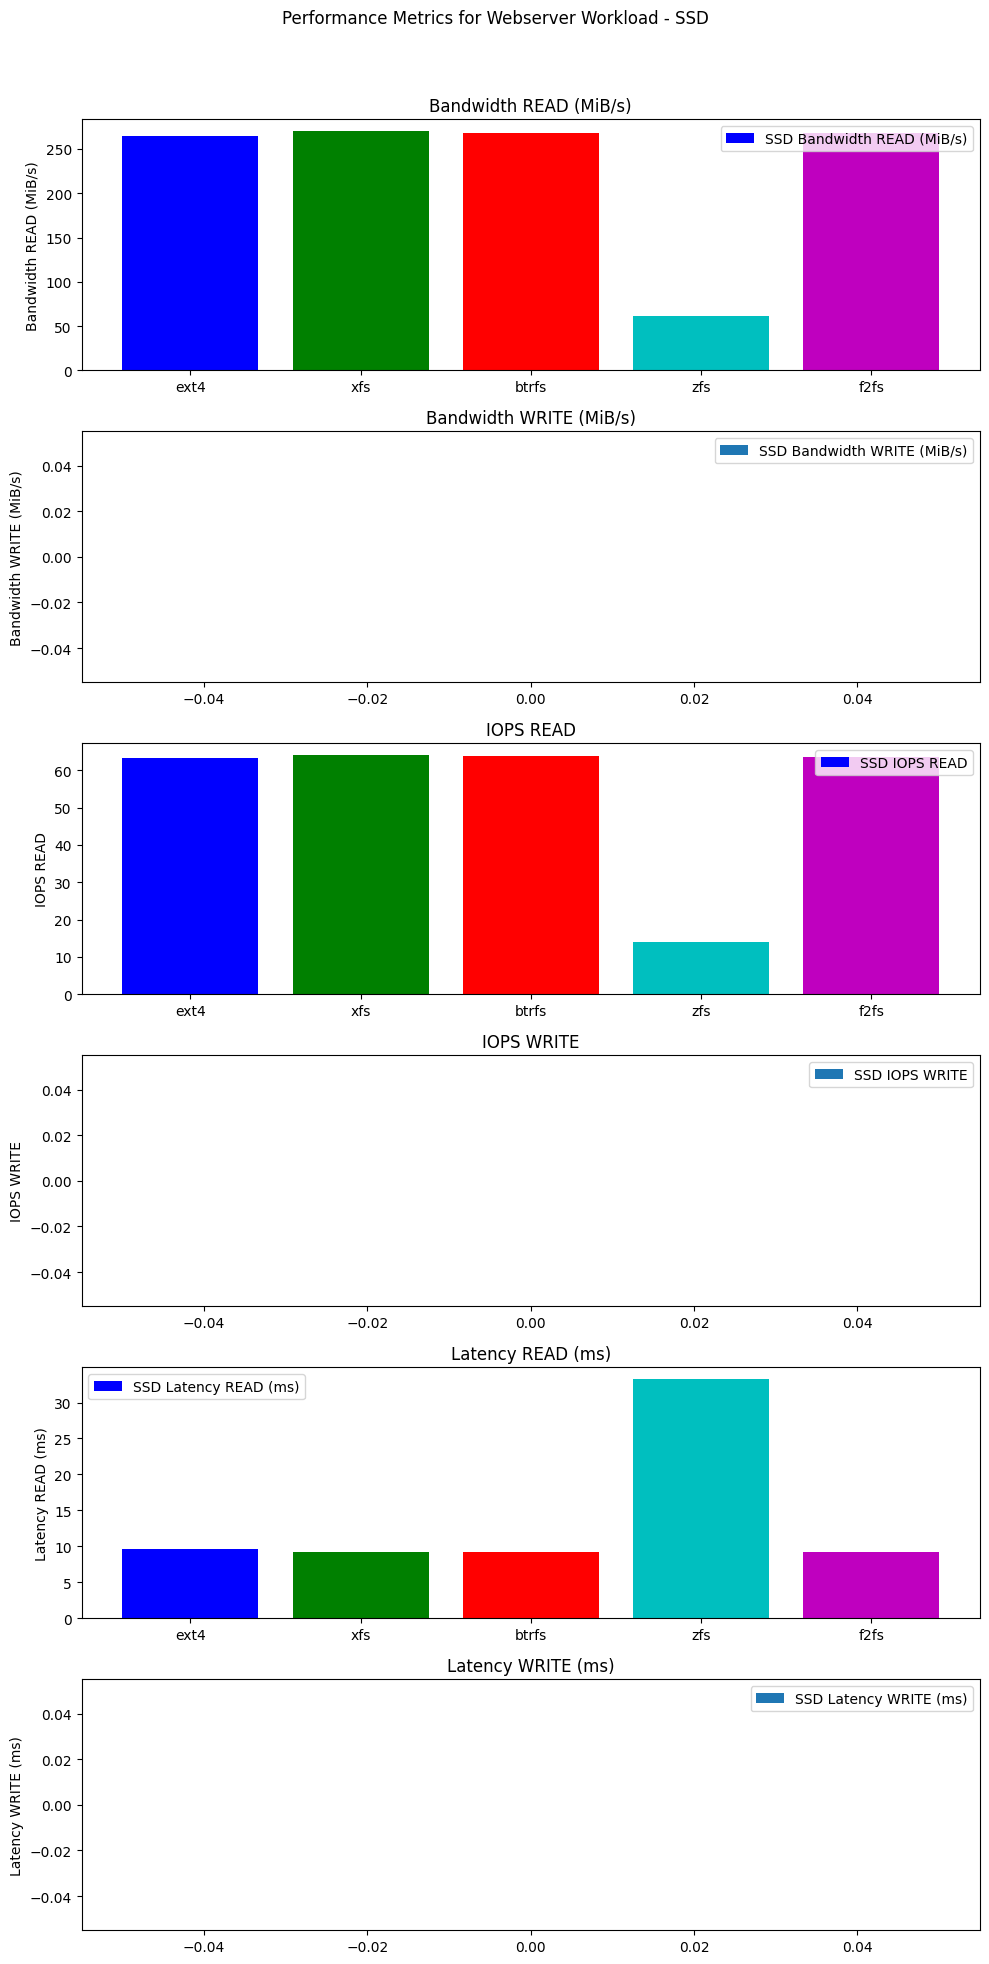

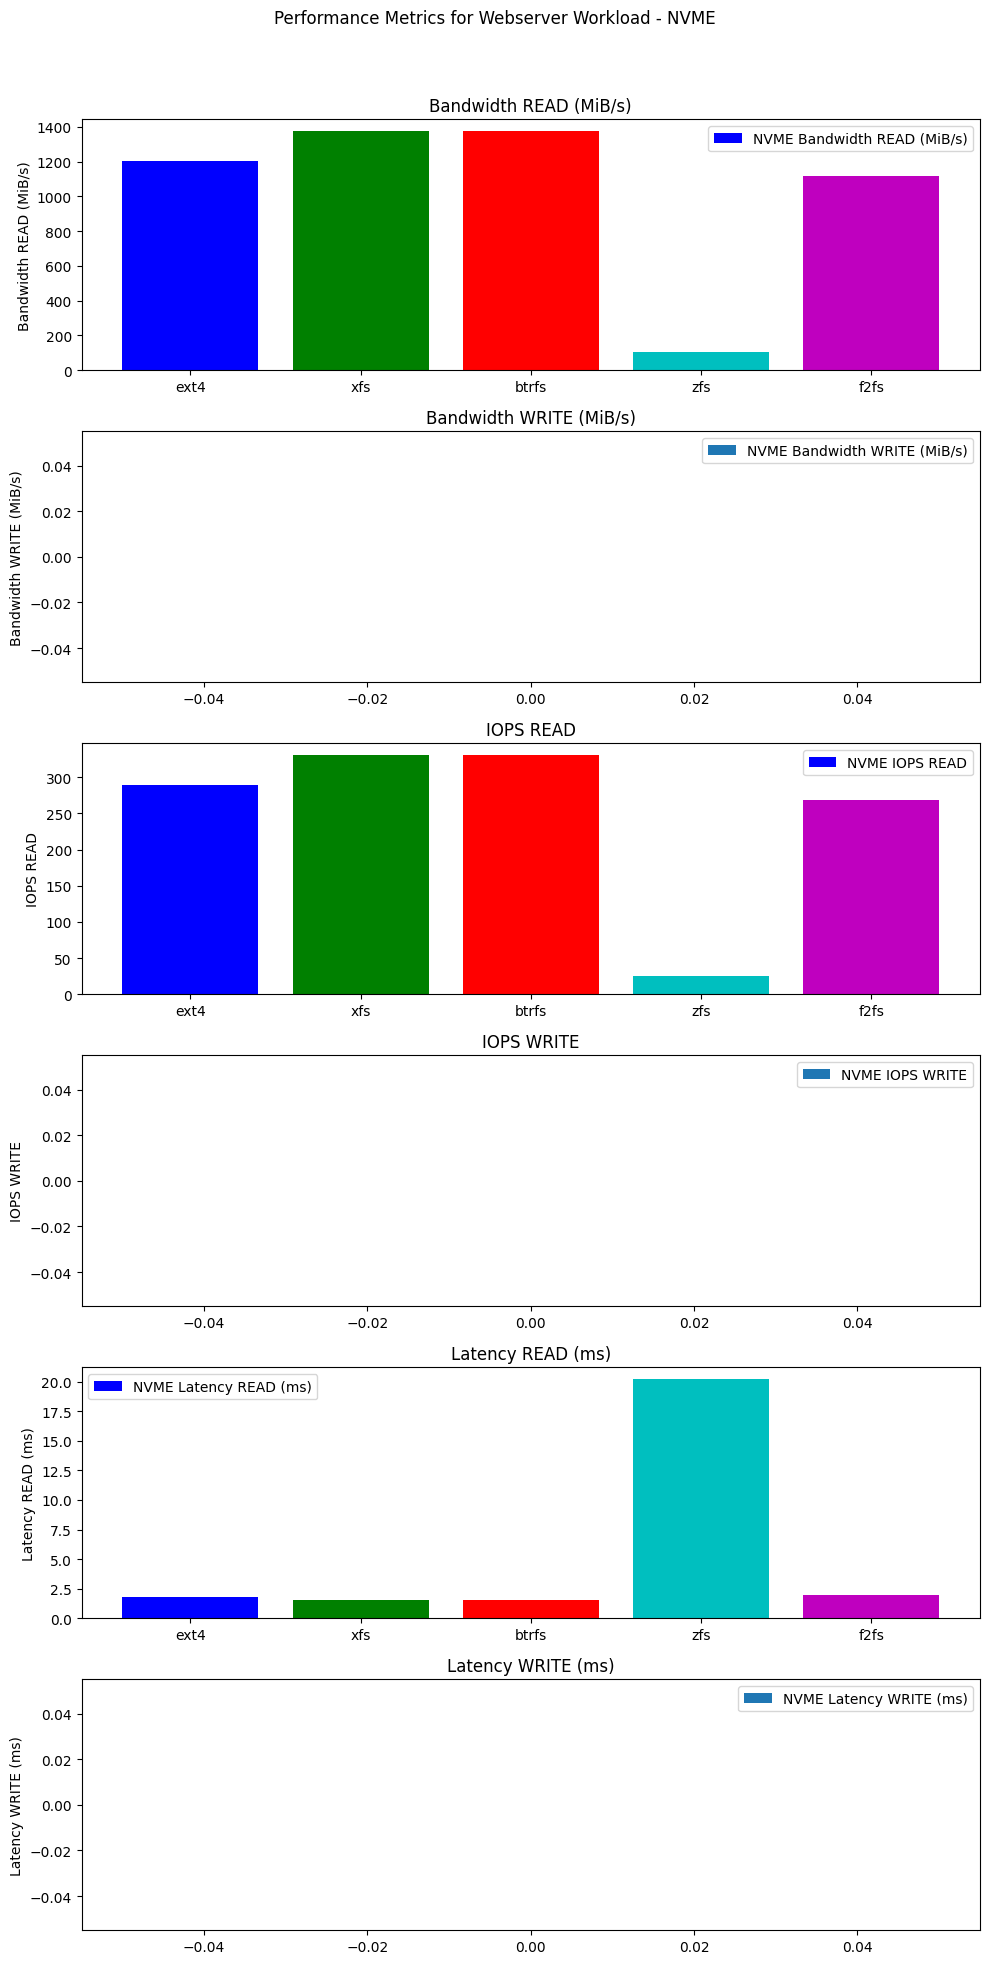

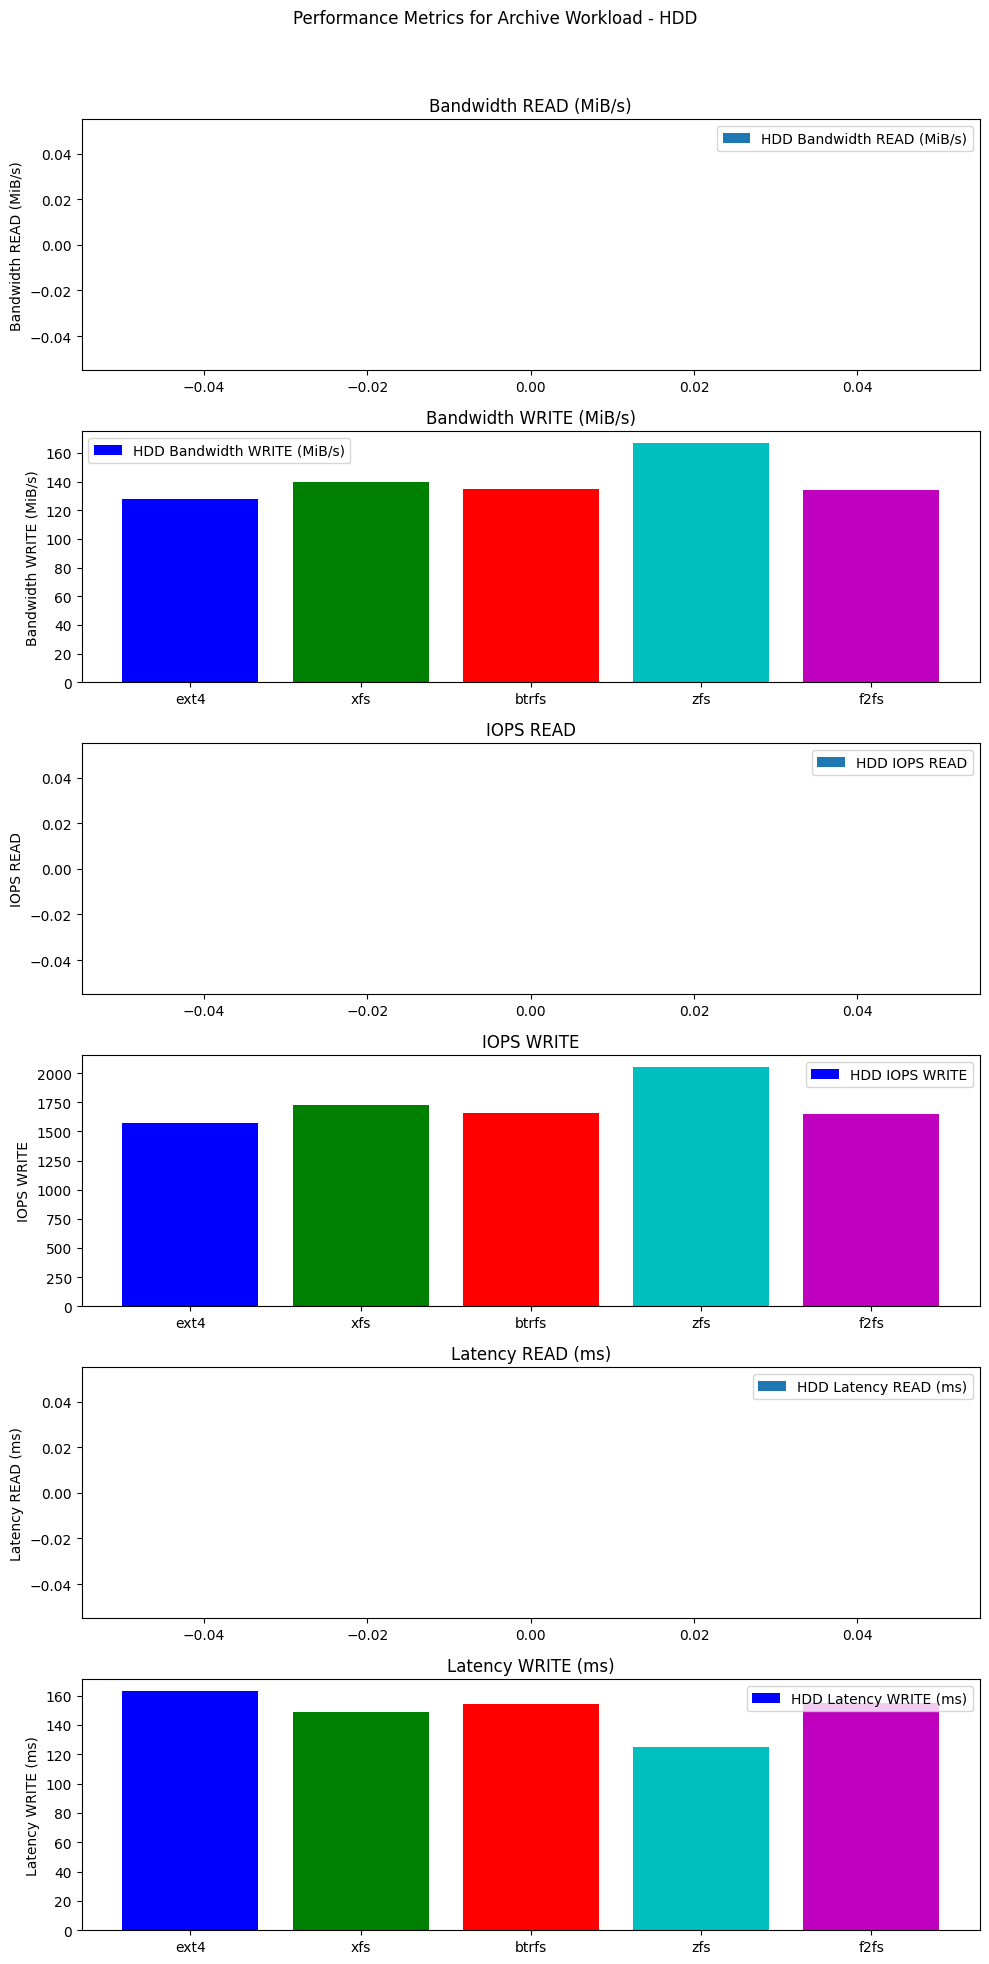

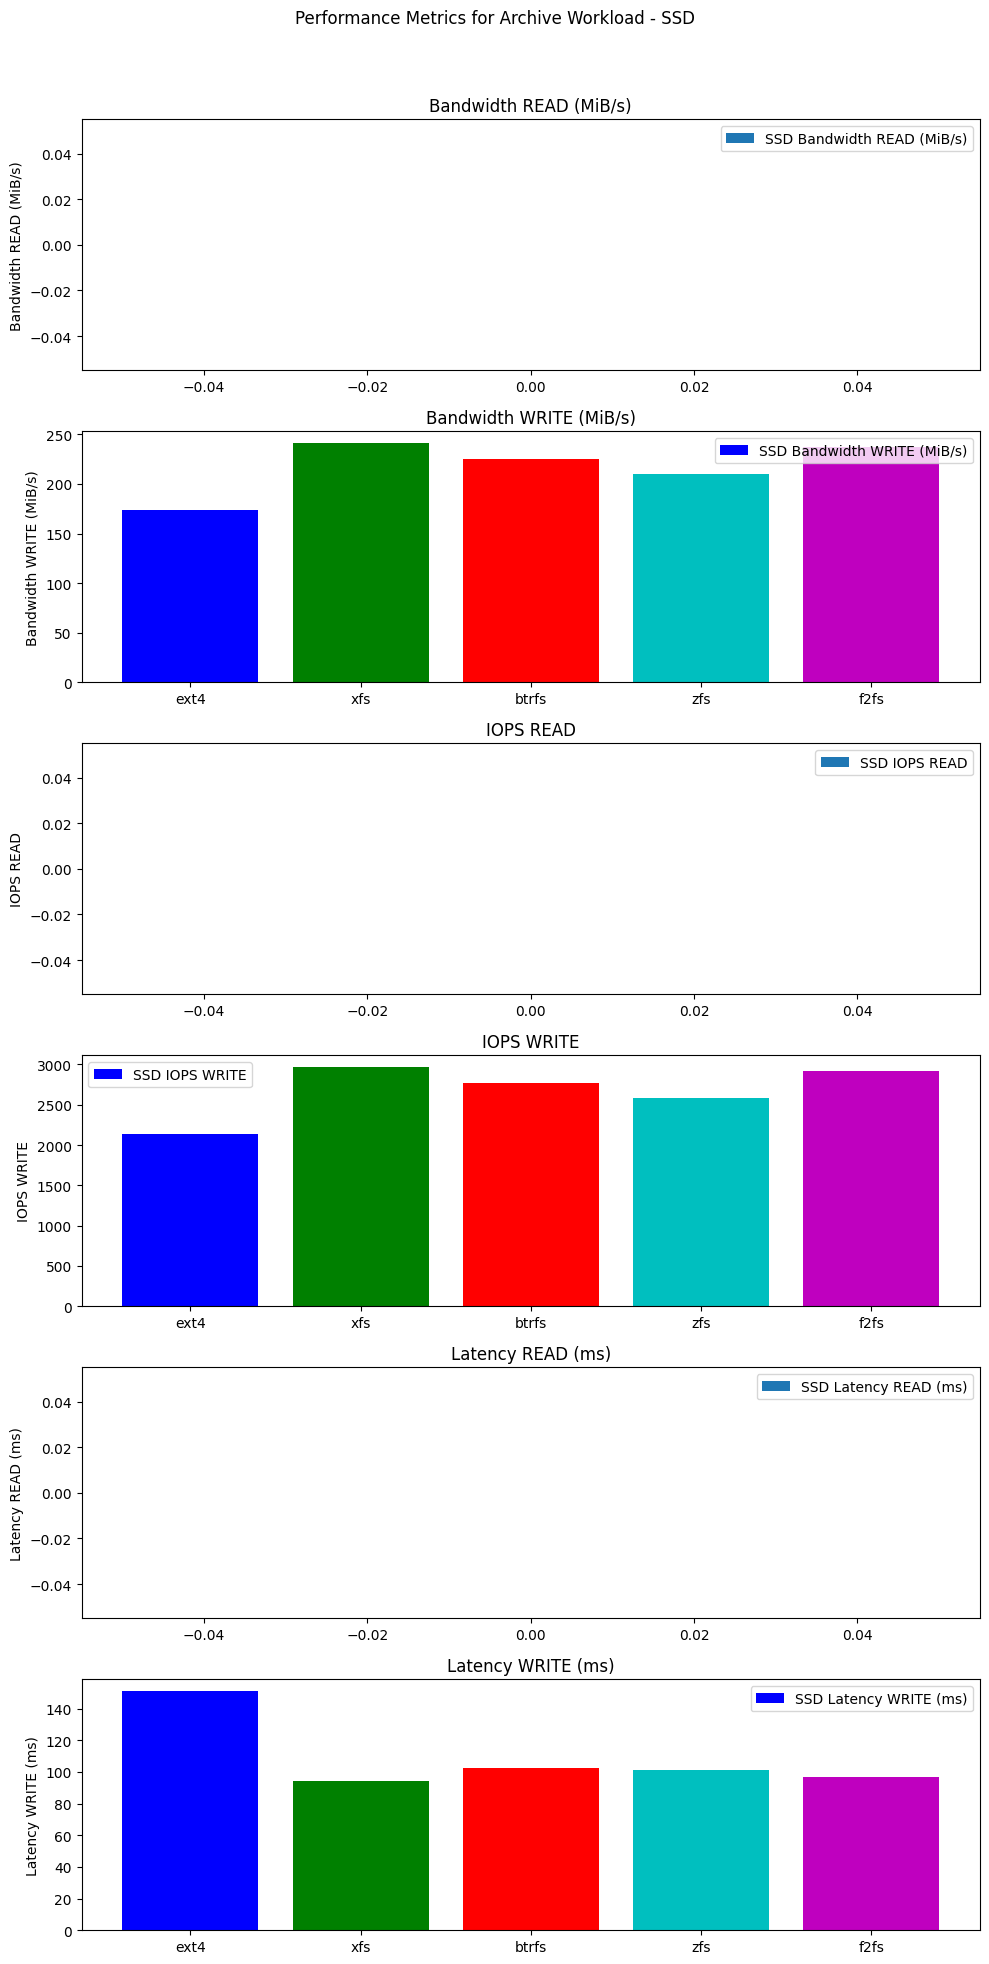

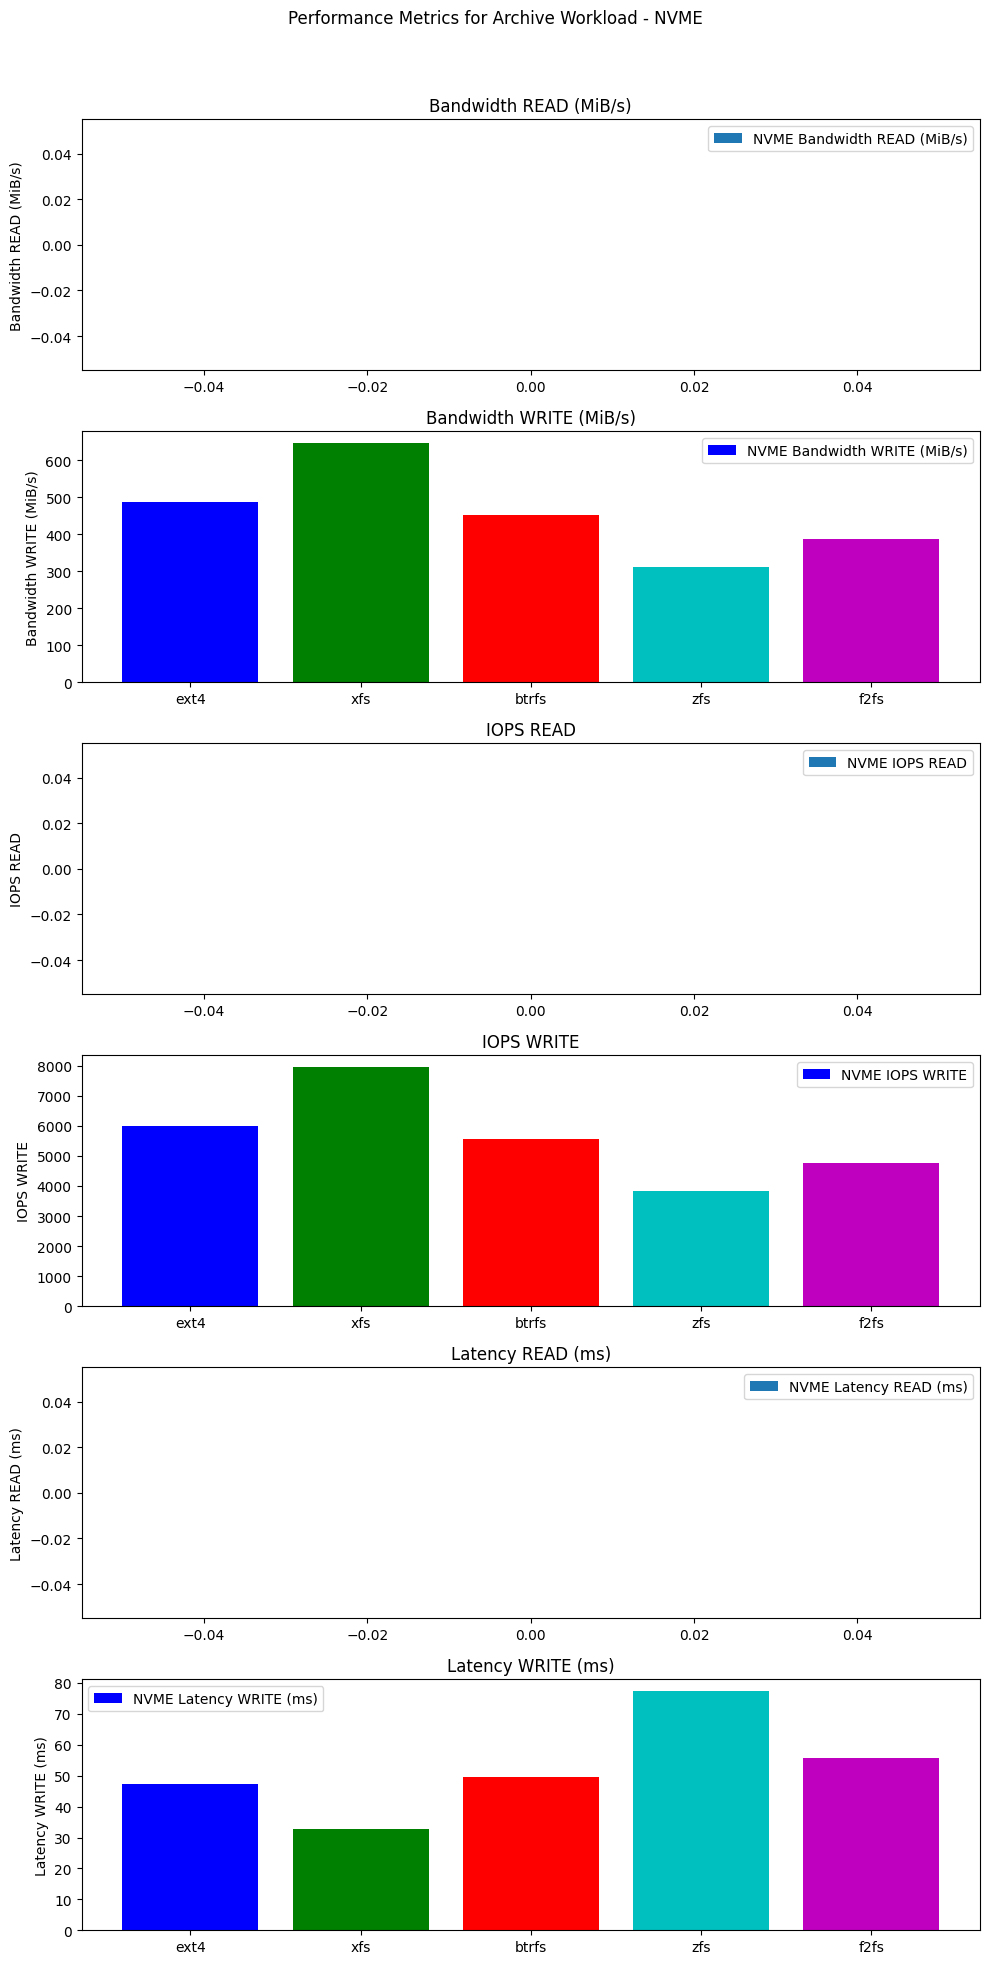

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot performance metrics
def plot_performance_metrics(data, workload):
    metrics = ["Bandwidth READ (MiB/s)", "Bandwidth WRITE (MiB/s)", "IOPS READ", "IOPS WRITE", "Latency READ (ms)", "Latency WRITE (ms)"]
    storage_types = ['HDD', 'SSD', 'NVME']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for different file systems
    
    for storage in storage_types:
        fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 20))
        fig.suptitle(f'Performance Metrics for {workload.capitalize()} Workload - {storage}')
        
        for i, metric in enumerate(metrics):
            fs_labels = []
            avg_values = []
            color_map = {}
            for idx, (fs, devices) in enumerate(data.items()):
                if storage.lower() in devices:
                    results = devices[storage.lower()]
                    if workload in results:
                        values = results[workload].get(metric, {})
                        if values:
                            fs_labels.append(fs)
                            avg_values.append(values['avg'])
                            color_map[fs] = colors[idx % len(colors)]  # Assign color to file system
            
            bars = axs[i].bar(fs_labels, avg_values, color=[color_map[fs] for fs in fs_labels], label=f'{storage} {metric}')
            axs[i].set_title(metric)
            axs[i].set_ylabel(metric)
            axs[i].legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Plot performance metrics for each workload
for workload in workloads:
    plot_performance_metrics(resultsdict, workload)